In [262]:
import torch
import numpy as np

In [263]:
torch.cuda.is_available()

True

In [297]:
def get_cam_stuff(h_fov_deg, pose, w, h):
    h_fov = np.deg2rad(h_fov_deg)
    focal_length = w / (2 * np.tan(h_fov / 2))
    pos = pose[0, :]
    dir_vec = pose[1, :]
    up_vec = pose[2, :]
    right_vec = pose[3, :]
    R_cw = torch.stack([right_vec, -up_vec, dir_vec], dim=0)
    pos_c = -R_cw @ pos
    K = torch.tensor([[focal_length, 0, w / 2],
                    [0, focal_length, h / 2],
                    [0, 0, 1]], dtype=torch.double, device='cuda')
    K_hom = torch.cat((K, torch.tensor([[0, 0, 0]], dtype=torch.double, device='cuda')))
    K_hom = torch.cat((K_hom, torch.tensor([[0, 0, 0, 1]], dtype=torch.double, device='cuda').t()), dim=1)
    E = torch.cat((R_cw, pos_c.view(3, 1)), dim=1)
    E_hom = torch.cat((E, torch.tensor([[0, 0, 0, 1]], dtype=torch.double, device='cuda')))
    C_cw = K_hom @ E_hom
    return K, R_cw, pos, C_cw    

In [298]:
im_h, im_w = 2592, 4608

pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046,
        -0.07876803246160267, 0.878472092968163, -0.4712561712468741,
        -0.04208625123151773, 0.46937312065726633, 0.8819963838144332,
        0.9960041890069568, 0.08930652540881052, -0.0]

pose = torch.tensor(pose, device='cuda', dtype=torch.double).view(4, 3)
pose

tensor([[ 5.4950e+05, -6.1283e+06,  3.2875e+06],
        [-7.8768e-02,  8.7847e-01, -4.7126e-01],
        [-4.2086e-02,  4.6937e-01,  8.8200e-01],
        [ 9.9600e-01,  8.9307e-02, -0.0000e+00]], device='cuda:0',
       dtype=torch.float64)

In [299]:
hfov = 66.0
K, R_cw, pos, C_cw = get_cam_stuff(hfov, pose, im_w, im_h)
x, y, z = pos

In [300]:
def get_pixel_coords(h, w):
    xs = torch.arange(0, w, device='cuda', dtype=torch.double) + 0.5
    ys = torch.arange(0, h, device='cuda', dtype=torch.double) + 0.5
    cartesian_prod = torch.cartesian_prod(xs, ys)
    pixel_locs = torch.cat((cartesian_prod, 1*torch.ones((w * h, 1), device='cuda', dtype=torch.double)), dim=1)
    return pixel_locs

In [301]:
pixel_locs = get_pixel_coords(im_h, im_w)
pixel_locs

tensor([[5.0000e-01, 5.0000e-01, 1.0000e+00],
        [5.0000e-01, 1.5000e+00, 1.0000e+00],
        [5.0000e-01, 2.5000e+00, 1.0000e+00],
        ...,
        [4.6075e+03, 2.5895e+03, 1.0000e+00],
        [4.6075e+03, 2.5905e+03, 1.0000e+00],
        [4.6075e+03, 2.5915e+03, 1.0000e+00]], device='cuda:0',
       dtype=torch.float64)

In [302]:
def get_ray_directions(pixel_locs, C_cw):
    C_cw_inv = torch.inverse(C_cw)
    pixel_locs_hom = torch.cat((pixel_locs, torch.zeros((im_w * im_h, 1), device='cuda', dtype=torch.double)), dim=1)
    ray_vecs = C_cw_inv @ pixel_locs_hom.t()
    ray_vecs = ray_vecs[:3] / torch.norm(ray_vecs[:3], dim=0)
    return ray_vecs.t()

In [303]:
vecs = get_ray_directions(pixel_locs, C_cw)
vecs

tensor([[-0.5941,  0.7954, -0.1196],
        [-0.5941,  0.7954, -0.1199],
        [-0.5942,  0.7953, -0.1201],
        ...,
        [ 0.4678,  0.6138, -0.6359],
        [ 0.4678,  0.6137, -0.6360],
        [ 0.4678,  0.6135, -0.6362]], device='cuda:0', dtype=torch.float64)

In [304]:
def cast_rays(vecs, x, y, z):
    semimaj = a = b = torch.tensor(6378137.0, device='cuda', dtype=torch.double)
    semimin = c = torch.tensor(6356752.31424518, device='cuda', dtype=torch.double)
    us = vecs[:, 0]
    vs = vecs[:, 1]
    ws = vecs[:, 2]
    value = -a**2*b**2*ws*z - a**2*c**2*vs*y - b**2*c**2*us*x
    radical = a**2*b**2*ws**2 + a**2*c**2*vs**2 - a**2*vs**2*z**2 + 2*a**2*vs*ws*y*z - a**2*ws**2*y**2 + b**2*c**2*us**2 - b**2*us**2*z**2 + 2*b**2*us*ws*x*z - b**2*ws**2*x**2 - c**2*us**2*y**2 + 2*c**2*us*vs*x*y - c**2*vs**2*x**2
    magnitude = a**2*b**2*ws**2 + a**2*c**2*vs**2 + b**2*c**2*us**2
    d = (value - a*b*c*torch.sqrt(radical)) / magnitude
    d[d < 0] = torch.nan
    xs = x + d * us
    ys = y + d * vs
    zs = z + d * ws
    return xs, ys, zs

In [305]:
x, y, z = pos
xs, ys, zs = cast_rays(vecs, x, y, z)
print(xs, ys, zs)

tensor([ 90074.0860,  90086.7246,  90099.3589,  ..., 910419.2521,
        910430.1207, 910440.9924], device='cuda:0', dtype=torch.float64) tensor([-5513215.3220, -5513304.4396, -5513393.5500,  ...,
        -5654747.7818, -5654825.0213, -5654902.2584], device='cuda:0',
       dtype=torch.float64) tensor([3195023.8006, 3194870.6931, 3194717.5884,  ..., 2796940.0546,
        2796781.4203, 2796622.7788], device='cuda:0', dtype=torch.float64)


In [306]:
def ecef_to_llh(xs, ys, zs): 
    a = torch.tensor(6378137.0, device='cuda', dtype=torch.double)
    c = torch.tensor(6356752.31424518, device='cuda', dtype=torch.double)
    f = (a - c) / a
    f_inv = 1.0/f
    e_sq = f * (2 - f)
    eps = e_sq / (1.0 - e_sq)
    p = torch.sqrt(xs**2 + ys**2)
    q = torch.atan2((zs * a), (p * c))
    sin_q = torch.sin(q)
    cos_q = torch.cos(q)
    sin_q_3 = sin_q**3
    cos_q_3 = cos_q**3
    phi = torch.atan2((zs + eps * c * sin_q_3), (p - e_sq * a * cos_q_3))
    lam = torch.atan2(ys, xs)
    v = a / torch.sqrt(1.0 - e_sq * torch.sin(phi)**2)
    h = p / torch.cos(phi) - v
    lat = torch.rad2deg(phi)
    lon = torch.rad2deg(lam)
    return(lon, lat, h)

In [307]:
lon, lat, h = ecef_to_llh(xs, ys, zs)
lon, lat, h

(tensor([-89.0640, -89.0639, -89.0638,  ..., -80.8538, -80.8538, -80.8538],
        device='cuda:0', dtype=torch.float64),
 tensor([30.2571, 30.2555, 30.2539,  ..., 26.1797, 26.1781, 26.1765],
        device='cuda:0', dtype=torch.float64),
 tensor([-1.8626e-09,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -9.3132e-10], device='cuda:0', dtype=torch.float64))

In [308]:
import rasterio
def get_region_im_and_transform(filepath):
    with rasterio.open(filepath) as src:
        transform = src.transform
        im = src.read()
    return im, transform

In [309]:
def get_indexes_from_coords(lon, lat, transform):
    lonlat = torch.stack((lon, lat, torch.ones_like(lon)), dim=1)
    indexes = torch.matmul(lonlat, transform.t())
    indexes = torch.round(indexes).int()
    return indexes

In [310]:
def get_inbounds_indexes(indexes, im_h, im_w):
    inbounds = (indexes[:, 0] >= 0) & (indexes[:, 0] < im_w) & (indexes[:, 1] >= 0) & (indexes[:, 1] < im_h)
    return inbounds

In [311]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
def get_base_im():
    base_im = torch.tensor(np.asarray(Image.open('world_jun.jpg')), device='cuda', dtype=torch.uint8)
    base_transform = rasterio.transform.from_origin(-180, 90, 0.016666667, 0.016666667)
    return base_im, base_transform
base_im, base_transform = get_base_im()
print(base_transform, base_im.shape)

| 0.02, 0.00,-180.00|
| 0.00,-0.02, 90.00|
| 0.00, 0.00, 1.00| torch.Size([10800, 21600, 3])


In [312]:
import matplotlib.pyplot as plt
new_im = torch.zeros((im_h, im_w, 3), device='cuda', dtype=torch.uint8)

In [280]:
tran_tensor = torch.tensor(~base_transform, device='cuda', dtype=torch.double).view(3,3)
indexes = get_indexes_from_coords(lon, lat, tran_tensor)
inbounds = get_inbounds_indexes(indexes, base_im.shape[0], base_im.shape[1])
in_indexes = indexes[inbounds]
pixel_locs = pixel_locs.int()
in_pl = pixel_locs[inbounds]
new_im[in_pl[:, 1], in_pl[:, 0], :] = base_im[in_indexes[:, 1], in_indexes[:, 0], :]

In [281]:
import time
#import rasterio.merge
files = ['l8_17R_00002.tif']#, 'l8_16R_00000.tif']
pixel_locs = pixel_locs.int()
start = time.time()
for file in files:
    data, tran = get_region_im_and_transform(file)
    #data, tran = rasterio.merge.merge(files)
    tran_tensor = torch.tensor(~tran, device='cuda', dtype=torch.double).view(3,3)
    indexes = get_indexes_from_coords(lon, lat, tran_tensor)
    regim = torch.tensor(data, device='cuda', dtype=torch.uint8).permute(1, 2, 0)
    regim_h, regim_w, _ = regim.shape
    inbounds = get_inbounds_indexes(indexes, regim_h, regim_w)
    in_indexes = indexes[inbounds]
    in_pl = pixel_locs[inbounds]
    inbounds2 = regim[in_indexes[:, 1], in_indexes[:, 0], :].sum(axis=-1) > 1
    in_indexes = in_indexes[inbounds2]
    in_pl = in_pl[inbounds2]
    # inbounds2 = regim[in_indexes[:, 1], in_indexes[:, 0], :].sum(axis=-1) != 0
    # in_indexes = in_indexes[inbounds2]
    # in_pl = in_pl[inbounds2]
    new_im[in_pl[:, 1], in_pl[:, 0], :] = regim[in_indexes[:, 1], in_indexes[:, 0], :]
    #plt.imshow(regim.cpu().numpy())
print(time.time() - start)

0.33196377754211426


In [282]:
# files = ['l8_17R_00002.tif', 'l8_16R_00000.tif']
# pixel_locs = pixel_locs.int()
# file = files[0]
# data, tran = get_region_im_and_transform(file)
# regim = torch.tensor(data, device='cuda', dtype=torch.uint8).permute(1, 2, 0)
# inbounds2 = regim[indexes[:, 1], indexes[:, 0], :].sum(axis=-1) != 0
# inbounds2

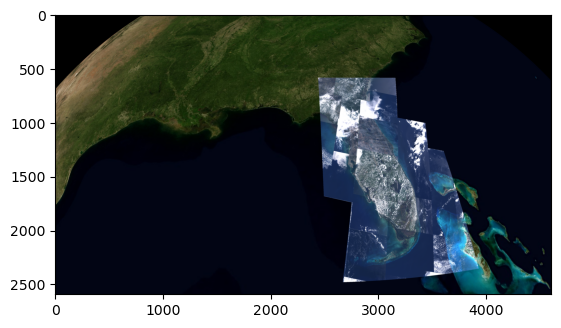

In [283]:
plt.imshow(new_im.cpu().numpy())

In [284]:
# inbounds = (indexes[:, 0] >= 0) & (indexes[:, 0] < im.shape[1]) & (indexes[:, 1] >= 0) & (indexes[:, 1] < im.shape[0])
# outbounds = ~inbounds
# pixel_locs = pixel_locs.int()
# in_indexes = indexes[inbounds]
# in_pl = pixel_locs[inbounds]

In [285]:
# # cam_pos = R_wc.t() @ pos
# # E = torch.cat((R_wc, -cam_pos.view(3, 1)), dim=1)
# # E_hom = torch.cat((E, torch.tensor([[0, 0, 0, 1]], dtype=torch.double, device='cuda')))
# # E, E_hom, cam_pos
# pos = pose[0, :]
# dir_vec = pose[1, :]
# up_vec = pose[2, :]
# right_vec = pose[3, :]
# viewPlaneHalfWidth = torch.tan(torch.deg2rad(torch.tensor(66.0))/2)
# viewPlaneHalfWidthright = viewPlaneHalfWidth * right_vec
# viewPlaneHalfHeight = 9/16 * viewPlaneHalfWidth
# viewPlaneHalfHeightup = up_vec * viewPlaneHalfHeight 
# viewtopLeftPoint = -viewPlaneHalfWidthright + viewPlaneHalfHeightup
# viewtopLeftPoint
# xincvector = (up_vec*2*torch.deg2rad(torch.tensor(66.0)/2))/im_w
# yincvector = (right_vec*2*torch.deg2rad(torch.tensor(9/16*66.0)/2))/im_h
# xincvector, yincvector
# tst = viewtopLeftPoint + xincvector*im_w/2 + yincvector*im_h/2
# tst_norm = tst / torch.norm(tst)
# tst_norm , dir_vec


In [286]:
# def get_ray_directions(pixel_locs, K, R_wc, pos):
#     inv_K = torch.inverse(K)
    
#     pixel_locs_t = pixel_locs.t()
#     pixel_locs_camera_frame = inv_K @ pixel_locs_t
#     translated_pixel_locs = (pixel_locs_camera_frame.t() + R_wc.t() @ pos).t()
#     ray_dirs = translated_pixel_locs.t() / torch.norm(translated_pixel_locs, dim=0).view(-1, 1)
#     return ray_dirs

In [287]:
# C_cw_inv = torch.inverse(C_cw)
# tstloc = C_cw_inv @ torch.tensor([0,2592, 1, 0], device='cuda', dtype=torch.double)
# tstloc_norm = tstloc[:3] / torch.norm(tstloc[:3])
# print(tstloc, tstloc_norm, dir_vec)
# pixel_locs_hom = torch.cat((pixel_locs, torch.zeros((im_h * im_w, 1), device='cuda', dtype=torch.double)), dim=1)
# tst = C_cw_inv @ pixel_locs_hom.t()
# tst = tst[:3, :]
# tst
# print(tstloc.reshape((4,1)).shape)
# xyz = cast_rays(tstloc.reshape((4,1)).t(), *pos)
# import pyproj
# # Define the ECEF and LLA coordinate systems
# ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
# lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

# # Define the XYZ coordinates
# x, y, z = (xyz[0].cpu(), xyz[1].cpu(), xyz[2].cpu())

# # Convert XYZ to LLA
# lon, lat, alt = pyproj.transform(ecef, lla, x, y, z, radians=False)



# # Print the results
# print(lon, lat, alt)


In [288]:
# pos_c = R_cw @ pos
# E = torch.concatenate([R_cw, -pos_c.view(3, 1)], dim=1)
# E_hom = torch.cat((E, torch.tensor([[0, 0, 0, 1]], dtype=torch.double, device='cuda')))
# print(E_hom)
# E_hom_inv = torch.inverse(E_hom)
# print(E_hom_inv)

# print(E_hom @ torch.tensor([*pos, 1], dtype=torch.double, device='cuda'))
# print(E_hom @ torch.tensor([*-dir_vec, 0], dtype=torch.double, device='cuda'))
# print(E_hom @ torch.tensor([*up_vec, 0], dtype=torch.double, device='cuda'))
# print(E_hom @ torch.tensor([*right_vec, 0], dtype=torch.double, device='cuda'))


In [289]:
# test = E_hom_inv @ torch.cat((pixel_locs, torch.ones((im_w * im_h, 1), device='cuda', dtype=torch.double)), dim=1).t()
# test = test / test[-1, :]
# test = test[:-1, :].t()
# print(test)
# vecs = test #- pos.view(1, 3)
# print(vecs)
# print(torch.norm(vecs, dim=1))
# vecs = vecs / torch.norm(vecs, dim=1).view(-1,1)

# vecs

#print(E_hom @ torch.tensor(0, 0, 0))

In [290]:
# R_wc = R_cw.t()
# inv_K = torch.inverse(K)
# pixel_locs_t = pixel_locs.t()
# pixel_locs_camera_frame = inv_K @ pixel_locs_t
# print(pixel_locs_camera_frame)
# print(torch.zeros((im_w * im_h, 1)).shape)
# #pixel_locs_camera_frame_hom = torch.cat((pixel_locs_camera_frame, -1*torch.zeros((im_w * im_h, 1), device='cuda', dtype=torch.double).t()), dim=0)
# #pixel_locs_world_frame = E_hom_inv @ pixel_locs_camera_frame_hom
# pixel_locs_world_frame = R_wc @ pixel_locs_camera_frame
# print(pixel_locs_world_frame)
# print(torch.norm(pixel_locs_world_frame, dim=0).view(-1, 1))
# pixel_locs_world_frame = pixel_locs_world_frame.t() / torch.norm(pixel_locs_world_frame, dim=0).view(-1, 1)
# pixel_locs_world_frame

In [291]:
# inv_K = torch.inverse(K)
# inv_K_hom = torch.cat((inv_K, torch.tensor([[0, 0, 0]], dtype=torch.double, device='cuda').view(3,1)), dim=1)
# inv_K_hom = torch.cat((inv_K_hom, torch.tensor([[0, 0, 0, 0]], dtype=torch.double, device='cuda').view(1,4)), dim=0)
# print(inv_K_hom)
# pixel_locs_ndc_x = ((pixel_locs[:, 0] + 0.5)/im_w) * 2 - 1
# pixel_locs_ndc_y = ((im_h - pixel_locs[:, 1] + 0.5)/im_h) * 2 - 1
# pixel_locs_ndc_z = -1 * torch.ones((im_w * im_h), device='cuda', dtype=torch.double)
# pixel_locs_ndc = torch.cat((pixel_locs_ndc_x.view(-1, 1), pixel_locs_ndc_y.view(-1, 1), pixel_locs_ndc_z.view(-1, 1)), dim=1)
# print(pixel_locs_ndc)
# pixel_locs_hom = torch.cat((pixel_locs, torch.ones((im_w * im_h, 1), device='cuda', dtype=torch.double)), dim=1)
# print(pixel_locs_hom)
# pview = inv_K_hom @ pixel_locs_hom.t()
# print(pview)
# #pview = torch.stack((pview[0, :], pview[1, :], pview[2, :], torch.zeros((im_w * im_h), device='cuda', dtype=torch.double)))
# #print(pview)
# qworld = E_hom_inv @ pview
# print(qworld, qworld.shape)
# vworld = qworld[:3, :]
# print(vworld, vworld.shape)
# vworld_norm = vworld / torch.norm(vworld, dim=0).view(1, -1)
# vworld_norm = vworld_norm.t()
# print(vworld_norm, vworld_norm.shape)
# vecs = tst

In [292]:











# inv_K = torch.inverse(K)
# inv_K_hom = torch.cat((inv_K, torch.tensor([[0, 0, 0]], dtype=torch.double, device='cuda').view(1, 3)), dim=0)
# print(inv_K)
# pixel_locs_t = pixel_locs.t()
# pixel_locs_t_hom = torch.cat((pixel_locs, torch.zeros((im_w * im_h, 1), device='cuda', dtype=torch.double)), dim=1).t()
# print(pixel_locs_t)
# #print((inv_K_hom @ E_hom_inv) @ pixel_locs_t_hom - pos.view(3, 1)) 
# #pixel_locs_camera_frame = (R_wc.t() @ inv_K @ pixel_locs_t).t() @ R_wc #- (E_hom_inv @ torch.tensor([0, 0, 0, 1], dtype=torch.double, device='cuda'))[:3]
# pixel_locs_camera_frame = (E_hom_inv @ inv_K_hom).t() @ pixel_locs_t_hom #- pos.view(3, 1)
# #pixel_locs_camera_frame = pixel_locs_camera_frame.t()
# #pixel_locs_camera_frame = pixel_locs_camera_frame/ torch.norm(pixel_locs_camera_frame, dim=1).view(-1, 1)
# print(pixel_locs_camera_frame)
# # pos_c = R_wc.t() @ pos
# # E = torch.concatenate([R_wc, -pos_c.view(3, 1)], dim=1)
# # E_hom = torch.cat((E, torch.tensor([[0, 0, 0, 1]], dtype=torch.double, device='cuda')))
# # E_hom_inv = torch.inverse(E_hom)
# # pos_c = E_hom_inv @ torch.tensor([0, 0, 0, 1], dtype=torch.double, device='cuda')
# # print(pos_c)
# # R_cw = R_wc.t()
# # pixel_locs_world_frame = R_wc @ (pixel_locs_camera_frame)
# # print(pixel_locs_world_frame)
# # translated_pixel_locs = (pixel_locs_camera_frame.t()).t()
# #print(translated_pixel_locs)
# #print(torch.norm(translated_pixel_locs, dim=0))
# print(torch.norm(pixel_locs_camera_frame, dim=1))
# normed_pixel_locs = pixel_locs_camera_frame / torch.norm(pixel_locs_camera_frame, dim=1).view(-1, 1)
# normed_pixel_locs = normed_pixel_locs / torch.norm(normed_pixel_locs, dim=0)
# ray_dirs = normed_pixel_locs
# vecs = ray_dirs
# print(vecs.t())

In [293]:
#vecs = get_ray_directions(pixel_locs, K, R_wc, pos)
# print(vecs)


In [294]:
#vecs = get_ray_directions(pixel_locs, K, R_wc, pos)
# # vecs = vecs.t()
# vecs

In [295]:
# a = tran_tensor @ torch.tensor([-80.6896, 30.2563, 1], device='cuda', dtype=torch.double)
# u = a[0]
# v = data.shape[1] - a[1]
# u, v

In [296]:
# lonlat = torch.stack((lon, lat, torch.ones_like(lon)), dim=1)
# indexes = torch.matmul(lonlat, tran_tensor.t())
# indexes = torch.round(indexes).int()
# indexes[:, 1] = indexes[:, 1]
# indexes
# print(indexes)